In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from multiprocessing import Pool
from timeit import default_timer as timer
from anomaly_fxns import get_dataframes 
import tqdm
from istarmap import istarmap
from anomaly_fxns import make_merge_dfs
from anomaly_fxns import merge_and_calc_ppt

In [2]:
# nar = pd.read_csv("C:\\Tara_Fall_2019\\Kenya_Drought\\random_samples\\narok_points_completed.csv").replace(-9999.000000, np.NaN)
# tur = pd.read_csv("C:\\Tara_Fall_2019\\Kenya_Drought\\random_samples\\turkana_points_completed.csv").replace(-9999.000000, np.NaN)

nar = pd.read_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\narpts_modis_chirp_chirt_sg.csv")
tur = pd.read_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\turpts_modis_chirp_chirt_sg.csv")

## MODIS new engineering

In [4]:
# create empty output dataframes
nar_out = nar[['FID', "Lat", "Lon"]]
tur_out = tur[['FID', "Lat", "Lon"]]

In [11]:
#weighted average of soil columns
#pass depth as a string value, either 30, 60 or 100
def weighted_avg_tex_new(df, depth, var):
    #pull all columns 
    all_cols = df.columns 
    #pull tex columns 
    var_cols = [col for col in all_cols if var in col]
    if var == "soc":
        new_col = (5/100)*df[(var+'_0-5cm_mean')] + (10/100)*df[(var+'_5-15cm_mean')] + (15/100)*df[(var+'_15-30cm_mean')] + (30/100)*df[(var+'_30-60cm_mean')] + (40/100)*df[(var+'_60-100cm_mean')]
    else: 
        new_col = (5/100)*df[(var+'_0-5cm_mean')] + (10/100)*df[(var+'_5-15cm_mean')] + (15/100)*df[(var+'_15-30cm_mean')] + (30/100)*df[(var+'_30-60cm_mean')] + (40/100)*df[(var+'_60-100cm_mean')]
    #return a series
    return (new_col)

In [12]:
# create full soil profile 
# loop over soil variables and depths
for var in ['sand', 'silt', 'clay', 'soc', 'bdod', 'cfvo']:
    for depth in ['100']:
        for df in [nar, tur]:
            df[(var + depth)] = weighted_avg_tex_new(df,depth,var)
            print (depth, var, " done.")

100 sand  done.
100 sand  done.
100 silt  done.
100 silt  done.
100 clay  done.
100 clay  done.
100 soc  done.
100 soc  done.
100 bdod  done.
100 bdod  done.
100 cfvo  done.
100 cfvo  done.


In [34]:
# Calculate mean annual temp 
years = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
for df in [nar, tur]:
    for year in years: 
        T_cols = [col for col in df.columns if "T" in col]
        year_measures = [col for col in T_cols if year in col]
        df[(year + "_avg_temp")] = df[year_measures].mean(axis = 1)

In [39]:
NPP_all = [col for col in nar.columns if "NPP" in col ]
NPP_tur = [col for col in NPP_all if ".1" not in col]
NPP_nar = [col for col in NPP_all if ".1" in col ]

In [41]:
# drop NPP columns from appropriate dataframes 
nar = nar.drop(NPP_tur, axis = 1)
tur = tur.drop(NPP_nar, axis = 1)

In [86]:
# calculate above ground biomass 
# AB = NPP * fANPP * treecovermultiplier  * slopesmultiplier 
def calculate_AB(row, year): 
    columns = list(row.index)
    #pull NPP for a given year
    NPP_col = [col for col in columns if "NPP" in col and year in col][0]
    # pull mean annual temp for given year 
    temp_col= [col for col in columns if "_avg_temp" in col and year in col][0]
    # pull LULC  
    lulc = row.LULC
    # pull slope 
    slope = row.slope
    
    
    # NPP 
    NPP = row[NPP_col]
    # mean annual temperature 
    MAT = row[temp_col]
    # fraction aboveground npp
    fANPP = (0.171) + (0.0129)*MAT 
    
    tree_cover_mult = 1
    # tree cover multiplier - this may need to be toggled  
    if lulc == 1: 
        tree_cover_mult = 0
    else: 
        tree_cover_mult = 1

    # slope multiplier 
    slope_multiplier = 1
    if slope <= 10: 
        slope_multiplier = 1
    elif (slope > 10) & (slope <= 30):
        slope_multiplier = .7
    elif (slope > 30) & (slope <= 60):
        slope_multiplier = .4 
    elif slope > 60:
        slope_multiplier = 0 
    
    
    # above ground biomass 
    AB = NPP * fANPP * tree_cover_mult * slope_multiplier
    
    
    return (AB)

In [88]:
years_t = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
for y in years_t: 
    col_new = y + '_AB'
    tur[col_new] = tur.apply(calculate_AB, year = y, axis = 1)
    print (y, " done.")
    
years_n = ["2000", "2001", "2002", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
for y in years_n: 
    col_new = y + '_AB'
    tur[col_new] = tur.apply(calculate_AB, year = y, axis = 1)
    print (y, " done.")

2000  done.
2001  done.
2002  done.
2003  done.
2004  done.
2005  done.
2006  done.
2007  done.
2008  done.
2009  done.
2010  done.
2011  done.
2012  done.
2013  done.
2014  done.
2015  done.
2016  done.
2000  done.
2001  done.
2002  done.
2005  done.
2006  done.
2007  done.
2008  done.
2009  done.
2010  done.
2011  done.
2012  done.
2013  done.
2014  done.
2015  done.
2016  done.


In [106]:
nar.columns

Index(['Unnamed: 0', 'FID', 'CID', 'Lat', 'Lon', '2000.01.02_8dayppt',
       '2000.01.10_8dayppt', '2000.01.18_8dayppt', '2000.01.26_8dayppt',
       '2000.02.03_8dayppt',
       ...
       '2008_avg_temp', '2009_avg_temp', '2010_avg_temp', '2011_avg_temp',
       '2012_avg_temp', '2013_avg_temp', '2014_avg_temp', '2015_avg_temp',
       '2016_avg_temp', '2000_AB'],
      dtype='object', length=2641)

In [108]:
tur = tur.drop(['Unnamed: 0.1', 'Unnamed: 0', 'FID', 'CID'], axis = 1)
nar = nar.drop([ 'Unnamed: 0', 'FID', 'CID'], axis = 1)

In [111]:
tur.to_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\turkana_AB_analysis.csv")
nar.to_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\narok_AB_analysis.csv")

## Data Quality Control

In [4]:
# fix NDVI columns 
def fix_ndvi(df): 
    #pull all columns 
    all_cols = df.columns
    #ndvi_columns 
    ndvi_cols = [col for col in all_cols if "F" in col and 'ppt' not in col]
    #loop over ndvi columns to mask values outside -1 to 1 with nan
    for col in ndvi_cols: 
        df[col].mask(~df[col].between(-1, 1), inplace=True)

In [5]:
# fix dtype
tur = tur.astype('float64')
nar = nar.astype('float64')

In [6]:
#apply ndvi correction function to both dataframes
fix_ndvi(nar)
fix_ndvi(tur)

In [8]:
#weighted average of soil columns
#pass depth as a string value, either 30, 60 or 100
def weighted_avg_tex(df, depth, var):
    #pull all columns 
    all_cols = df.columns 
    #pull tex columns 
    var_cols = [col for col in all_cols if var in col]
    if var == "soc":
        if depth == '30': 
            new_col = (5/30)*df[(var+'_0_5cm')] + (10/30)*df[(var+'_5_15cm')] + (15/30)*df[(var+'_15_30c')]
        elif depth == '60': 
            new_col = (5/60)*df[(var+'_0_5cm')] + (10/60)*df[(var+'_5_15cm')] + (15/60)*df[(var+'_15_30c')] + (30/60)*df[(var+'_30_60c')]
        elif depth == '100': 
            new_col = (5/100)*df[(var+'_0_5cm')] + (10/100)*df[(var+'_5_15cm')] + (15/100)*df[(var+'_15_30c')] + (30/100)*df[(var+'_30_60c')] + (40/100)*df[(var+'_60_100')]
    else: 
        if depth == '30': 
            new_col = (5/30)*df[(var+'_0_5cm')] + (10/30)*df[(var+'_5_15c')] + (15/30)*df[(var+'_15_30')]
        elif depth == '60': 
            new_col = (5/60)*df[(var+'_0_5cm')] + (10/60)*df[(var+'_5_15c')] + (15/60)*df[(var+'_15_30')] + (30/60)*df[(var+'_30_60')]
        elif depth == '100': 
            new_col = (5/100)*df[(var+'_0_5cm')] + (10/100)*df[(var+'_5_15c')] + (15/100)*df[(var+'_15_30')] + (30/100)*df[(var+'_30_60')] + (40/100)*df[(var+'_60_10')]
    #return a series
    return (new_col)

In [8]:
# loop over soil variables and depths
for var in ['sand', 'silt', 'clay', 'soc', 'bdod', 'cfvo']:
    for depth in ['30', '60', '100']:
        for df in [nar, tur]:
            df[(var + depth)] = weighted_avg_tex(df,depth,var)
            print (depth, var, " done.")

30 sand  done.
30 sand  done.
60 sand  done.
60 sand  done.
100 sand  done.
100 sand  done.
30 silt  done.
30 silt  done.
60 silt  done.
60 silt  done.
100 silt  done.
100 silt  done.
30 clay  done.
30 clay  done.
60 clay  done.
60 clay  done.
100 clay  done.
100 clay  done.
30 soc  done.
30 soc  done.
60 soc  done.
60 soc  done.
100 soc  done.
100 soc  done.
30 bdod  done.
30 bdod  done.
60 bdod  done.
60 bdod  done.
100 bdod  done.
100 bdod  done.
30 cfvo  done.
30 cfvo  done.
60 cfvo  done.
60 cfvo  done.
100 cfvo  done.
100 cfvo  done.


In [9]:
# drop all columns which are mssing texture data 
tur = tur.drop(tur[tur['sand30'] == 0].index)
nar = nar.drop(nar[nar['sand30'] == 0].index)

In [10]:
tur.to_csv("turkana_raw_w_soils.csv")
nar.to_csv("narok_raw_w_soils.csv")

## Get anomalies NEW

In [2]:
# import rangeland data 
tur = pd.read_csv("turkana_raw_w_soils.csv")
nar = pd.read_csv("narok_raw_w_soils.csv")

In [3]:
# pull ndvi columns for turkana and narok
ndvi_cols_t = [col for col in tur.columns if "F" in col and 'ppt' not in col]
ndvi_cols_n = [col for col in nar.columns if "F" in col and 'ppt' not in col]

In [4]:
# get the dates in the format of precipitation columns
ndvi_dates_t = [col[1:5] + "_"+ col[5:7]+"_"+col[7:] for col in ndvi_cols_t]
ndvi_dates_n = [col[1:5] + "_"+ col[5:7]+"_"+col[7:] for col in ndvi_cols_n]

In [5]:

ppt_col_list = [col for col in tur.columns if "ppt" in col]


In [6]:
# create bones for new ppt dataframes
precip_df_t = pd.DataFrame(ndvi_cols_t, columns = ['Date'])
precip_df_t['ppt_date'] = ndvi_dates_t

precip_df_n = pd.DataFrame(ndvi_cols_n, columns = ['Date'])
precip_df_n['ppt_date'] = ndvi_dates_n

In [7]:
# calculate mean NDVI for each row 
tur['mean_NDVI'] = tur[ndvi_cols_t].mean(axis = 1)
nar['mean_NDVI'] = nar[ndvi_cols_n].mean(axis = 1)
tur['stdv_NDVI'] = tur[ndvi_cols_t].std(axis = 1)
nar['stdv_NDVI'] = nar[ndvi_cols_n].std(axis = 1)

In [11]:
tur_by_date = pd.melt(tur, id_vars=['Unnamed: 0'], value_vars=ndvi_cols_t, var_name='Date', value_name='NDVI_value').dropna()
nar_by_date = pd.melt(nar, id_vars=['Unnamed: 0'], value_vars=ndvi_cols_n, var_name='Date', value_name='NDVI_value').dropna()

In [13]:
tur_plus_mean = tur_by_date.merge(tur[["mean_NDVI", "stdv_NDVI", "cropland", "trees", "grassland", "shrub", "Unnamed: 0"]], how = "left", left_on = "Unnamed: 0", right_on = "Unnamed: 0")
nar_plus_mean = nar_by_date.merge(nar[["mean_NDVI", "stdv_NDVI", "cropland", "trees", "grassland", "shrub", "Unnamed: 0"]], how = "left", left_on = "Unnamed: 0", right_on = "Unnamed: 0")

In [14]:
merge_cols = [col for col in tur.columns if "ppt" in col or col in ["Unnamed: 0"]]

In [15]:
tur_plus_mean.name = "tur_plus_mean"
nar_plus_mean.name = "nar_plus_mean"

#use the full set
base_sets = [tur_plus_mean, nar_plus_mean]

#pull unique dates for each 
dates = [list(tur_plus_mean.Date.unique()), list(nar_plus_mean.Date.unique())]

In [16]:
arguments_t = [(base_sets[0], date) for date in dates[0]]
arguments_n = [(base_sets[1], date) for date in dates[1]]
arguments = arguments_t + arguments_n

In [17]:
# PARALLEL SPLIT DATA BY REGION AND DATE
if __name__ == '__main__':

    with Pool(14) as pool:
        result = []
        for _ in tqdm.tqdm(pool.istarmap(get_dataframes, arguments),
                           total=len(arguments)):
            result.append(_)
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 526/526 [24:31<00:00,  2.80s/it]


In [18]:
tur_date_dfs = result[:420]
nar_date_dfs = result[420:]

In [23]:
# prep for pulling merge specific columns for each date
ppt_arg_t = [(tur, date) for date in dates[0]]
ppt_arg_n = [(nar, date) for date in dates[1]]

In [24]:
arguments = ppt_arg_t
# PARALLEL PULL MERGE DFS FOR EACH REGION X DATE
if __name__ == '__main__':

    with Pool(14) as pool:
        result_t = []
        for _ in tqdm.tqdm(pool.istarmap(make_merge_dfs, arguments),
                           total=len(arguments)):
            result_t.append(_)
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [32:07<00:00,  4.59s/it]


In [25]:
arguments = ppt_arg_n
# PARALLEL PULL MERGE DFS FOR EACH REGION X DATE
if __name__ == '__main__':

    with Pool(14) as pool:
        result_n = []
        for _ in tqdm.tqdm(pool.istarmap(make_merge_dfs, arguments),
                           total=len(arguments)):
            result_n.append(_)
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [07:39<00:00,  4.33s/it]


In [26]:
final_arg_t = list(zip(tur_date_dfs, result_t))
final_arg_n = list(zip(nar_date_dfs, result_n))

In [27]:
arguments = final_arg_t
# PARALLEL PULL MERGE DFS FOR EACH REGION X DATE
if __name__ == '__main__':

    with Pool(14) as pool:
        final_t = []
        for _ in tqdm.tqdm(pool.istarmap(merge_and_calc_ppt, arguments),
                           total=len(arguments)):
            final_t.append(_)
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [00:29<00:00, 14.06it/s]


In [28]:
arguments = final_arg_n
# PARALLEL PULL MERGE DFS FOR EACH REGION X DATE
if __name__ == '__main__':

    with Pool(14) as pool:
        final_n = []
        for _ in tqdm.tqdm(pool.istarmap(merge_and_calc_ppt, arguments),
                           total=len(arguments)):
            final_n.append(_)
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:12<00:00,  8.38it/s]


In [29]:
FINAL_T = pd.concat(final_t)
FINAL_N = pd.concat(final_n)

In [30]:
FINAL_T.to_csv("TURKANA_ANOMALIES.csv")
FINAL_N.to_csv("NAROK_ANOMALIES.csv")

## Get anomalies OLD

In [3]:
def find_ndvi_anomalies(df): 
    
    # pull ndvi columns 
    ndvi_cols = [col for col in df.columns if "F" in col and 'ppt' not in col]
    # calculate row wise quantile 
    Q1 = df[ndvi_cols].quantile(q=.25, axis = 1)
    Q4 = df[ndvi_cols].quantile(q=.75, axis = 1)
    
    in_Q1 = df[ndvi_cols].le(Q1, axis = 0).dot(df[ndvi_cols].columns + ',').str.rstrip(',').str.split(',')
    in_Q4 = df[ndvi_cols].ge(Q4, axis = 0).dot(df[ndvi_cols].columns + ',').str.rstrip(',').str.split(',')
    
    return(in_Q1, in_Q4)

In [4]:
in_Q1, in_Q4 = find_ndvi_anomalies(nar)
nar['in_Q1'] = in_Q1
nar['in_Q4'] = in_Q4
in_Q1t, in_Q4t = find_ndvi_anomalies(tur)
tur['in_Q1'] = in_Q1t
tur['in_Q4'] = in_Q4t

In [14]:
def get_anom_records_Q1(row):
    # for each row - df.apply this function
    #pull lists of anomalies 
    Q1_anoms = row['in_Q1']
    
    # change col titles in anomaly lists so they will match dates in ppt data 
    Q1_dates = [(col[1:5] + "_" + col[5:7] + "_" + col[7:]) for col in Q1_anoms]
    
    # loop over list, take average ppt for all dates 16 days prior to that date 
    # make pandas series for each row x anomaly
    ppt_col_list = [col for col in row.index if "ppt" in col]
    #create a list to store new columns for each row - list of lists
    row_df_Q1 = []
    row_df_cols = ["point_index", "anomaly_date", "anomaly_value", "16dayppt_before_date", 
                  "16dayppt_mean", "16dayppt_max", "16dayppt_min", "16dayppt_median", "16dayppt_std", "16dayppt_q1",
                  "16dayppt_q4"]
    try:
        for date in Q1_dates:
            row_anom_list_Q1 = []
            #append row index
            row_anom_list_Q1.append(row['Unnamed: 0'])
            #append date
            row_anom_list_Q1.append(date)
            #append anomaly value 
            row_anom_list_Q1.append(row[("F" + date.replace("_", ""))])

            #create date col name
            date_col = "F" + date + "ppt"
            # get index of date col among all ppt columns
            index_of_date = ppt_col_list.index(date_col) 

            if (index_of_date - 16) >=0:
                # get the 16 columns before that date
                cols_b4 = ppt_col_list[(index_of_date - 16): index_of_date]
                # get the cumulative ppt over the past 16 days 
                sum_ppt = row[cols_b4].sum()
                # get the mean ppt over the past 16 days 
                mean_ppt = row[cols_b4].mean()
                # get the max ppt over the past 16 days 
                max_ppt = row[cols_b4].max()
                # get the min ppt over the past 16 days 
                min_ppt = row[cols_b4].min()
                # get the median ppt over the past 16 days 
                median_ppt = row[cols_b4].median()
                # get the median ppt over the past 16 days 
                std_ppt = row[cols_b4].std()
                #upper and lower quantiles 
                pptq1 = row[cols_b4].quantile(q=.25)
                pptq4 = row[cols_b4].quantile(q=.75)
                #append 16 day cumulative precip before date 
                row_anom_list_Q1.append(sum_ppt)
                row_anom_list_Q1.append(mean_ppt)
                row_anom_list_Q1.append(max_ppt)
                row_anom_list_Q1.append(min_ppt)
                row_anom_list_Q1.append(median_ppt)
                row_anom_list_Q1.append(std_ppt)
                row_anom_list_Q1.append(pptq1)
                row_anom_list_Q1.append(pptq4)
                
            else: 
                # no sum data
                row_anom_list_Q1.append(np.NaN)
                # no mean data
                row_anom_list_Q1.append(np.NaN)
                # no max data
                row_anom_list_Q1.append(np.NaN)
                # no min data 
                row_anom_list_Q1.append(np.NaN)
                # no median data 
                row_anom_list_Q1.append(np.NaN)
                # no std data 
                row_anom_list_Q1.append(np.NaN)
                # no pptq1
                row_anom_list_Q1.append(np.NaN)
                # no pptq4
                row_anom_list_Q1.append(np.NaN)

            #append row_anom_list to row_df
            row_df_Q1.append(row_anom_list_Q1)
    except:
        pass
    #create dataframe for the given row     
    Q1_df_rowx = pd.DataFrame(row_df_Q1, columns = row_df_cols).set_index("point_index") 
    
    #return row-specific dataframes 
    return (Q1_df_rowx)

def get_anom_records_Q4(row):
    # for each row - df.apply this function
    #pull lists of anomalies 
    Q4_anoms = row['in_Q4']
    
    # change col titles in anomaly lists so they will match dates in ppt data 
    Q4_dates = [(col[1:5] + "_" + col[5:7] + "_" + col[7:]) for col in Q4_anoms]
    
    # loop over list, take average ppt for all dates 16 days prior to that date 
    # make pandas series for each row x anomaly
    ppt_col_list = [col for col in row.index if "ppt" in col]
    #create a list to store new columns for each row - list of lists
    row_df_Q4 = []
    row_df_cols = ["point_index", "anomaly_date", "anomaly_value", "16dayppt_before_date", 
                  "16dayppt_mean", "16dayppt_max", "16dayppt_min", "16dayppt_median", "16dayppt_std", "16dayppt_q1",
                  "16dayppt_q4"]
    try:
        for date in Q4_dates:
            row_anom_list_Q4 = []
            #append row index
            row_anom_list_Q4.append(row['Unnamed: 0'])
            #append date
            row_anom_list_Q4.append(date)
            #append anomaly value 
            row_anom_list_Q4.append(row[("F" + date.replace("_", ""))])

            #create date col name
            date_col = "F" + date + "ppt"
            # get index of date col among all ppt columns
            index_of_date = ppt_col_list.index(date_col) 

            if (index_of_date - 16) >=0:
                # get the 16 columns before that date
                cols_b4 = ppt_col_list[(index_of_date - 16): index_of_date]
                # get the cumulative ppt over the past 16 days 
                sum_ppt = row[cols_b4].sum()
                # get the mean ppt over the past 16 days 
                mean_ppt = row[cols_b4].mean()
                # get the max ppt over the past 16 days 
                max_ppt = row[cols_b4].max()
                # get the min ppt over the past 16 days 
                min_ppt = row[cols_b4].min()
                # get the median ppt over the past 16 days 
                median_ppt = row[cols_b4].median()
                # get the median ppt over the past 16 days 
                std_ppt = row[cols_b4].std()
                #upper and lower quantiles 
                pptq1 = row[cols_b4].quantile(q=.25)
                pptq4 = row[cols_b4].quantile(q=.75)
                #append 16 day cumulative precip before date 
                row_anom_list_Q4.append(sum_ppt)
                row_anom_list_Q4.append(mean_ppt)
                row_anom_list_Q4.append(max_ppt)
                row_anom_list_Q4.append(min_ppt)
                row_anom_list_Q4.append(median_ppt)
                row_anom_list_Q4.append(std_ppt)
                row_anom_list_Q4.append(pptq1)
                row_anom_list_Q4.append(pptq4)
            else: 
                # no sum data
                row_anom_list_Q4.append(np.NaN)
                # no mean data
                row_anom_list_Q4.append(np.NaN)
                # no max data
                row_anom_list_Q4.append(np.NaN)
                # no min data 
                row_anom_list_Q4.append(np.NaN)
                # no median data 
                row_anom_list_Q4.append(np.NaN)
                # no std data 
                row_anom_list_Q4.append(np.NaN)
                # no pptq1
                row_anom_list_Q4.append(np.NaN)
                # no pptq4
                row_anom_list_Q4.append(np.NaN)

            #append row_anom_list to row_df
            row_df_Q4.append(row_anom_list_Q4)
    except: 
        pass
    
    #create dataframe for the given row     
    Q4_df_rowx = pd.DataFrame(row_df_Q4, columns = row_df_cols).set_index("point_index") 
    
    #return row-specific dataframes 
    return (Q4_df_rowx)

In [15]:
# Q1_nar_df = pd.concat(list(nar[~nar.in_Q1.str.len().eq(1)].apply(get_anom_records_Q1, axis = 1)))
# Q4_nar_df = pd.concat(list(nar[~nar.in_Q4.str.len().eq(1)].apply(get_anom_records_Q4, axis = 1)))


Q1_tur_df = pd.concat(list(tur[~tur.in_Q1.str.len().eq(1)].apply(get_anom_records_Q1, axis = 1)))
Q4_tur_df = pd.concat(list(tur[~tur.in_Q4.str.len().eq(1)].apply(get_anom_records_Q4, axis = 1)))

In [16]:
# Q1_nar_df.to_csv("Q1_narok_anomalies_NEW.csv")
# Q4_nar_df.to_csv("Q4_narok_anomalies_NEW.csv")
Q1_tur_df.to_csv("Q1_turkana_anomalies_NEW.csv")
Q4_tur_df.to_csv("Q4_turkana_anomalies_NEW.csv")

## Feature Engineering

In [25]:
# calculate mean NDVI for a year 
def stats_ann(year, df):
    # input year as a string and dataframe
    # pull columns from dataframe
    all_columns = df.columns
    # find columns which match the year
    annual_columns = [col for col in all_columns if year in col]
    # within the year, find precip columns
    ppt_columns = [col for col in annual_columns if 'ppt' in col]
    # ndvi columns should be remaining columns in annual columns 
    ndvi_columns = list(set(annual_columns).difference(ppt_columns))
    
    #calculate mean ppt 
    mean_ppt = df[ppt_columns].mean(axis = 1)
    # calculate mean ndvi 
    mean_ndvi = df[ndvi_columns].mean(axis = 1)
    
    #calculate max ppt 
    max_ppt = df[ppt_columns].max(axis = 1)
    # calculate max ndvi 
    max_ndvi = df[ndvi_columns].max(axis = 1)
    
    #calculate min ppt 
    min_ppt = df[ppt_columns].min(axis = 1)
    # calculate min ndvi 
    min_ndvi = df[ndvi_columns].min(axis = 1)
    
    #calculate std ppt 
    std_ppt = df[ppt_columns].std(axis = 1)
    # calculate std ndvi 
    std_ndvi = df[ndvi_columns].std(axis = 1)
    
    #calculate cumulative ppt
    cum_ppt = df[ppt_columns].sum(axis = 1)
    
    # make a dataframe with the above outputs
    df_out = pd.DataFrame({
    'mean_ppt': mean_ppt,
    'mean_ndvi': mean_ndvi, 
    'max_ppt': max_ppt,
    'max_ndvi': max_ndvi, 
    'min_ppt': min_ppt,
    'min_ndvi': min_ndvi,
    'std_ppt': std_ppt,
    'std_ndvi': std_ndvi,
    'cum_ppt': cum_ppt
    })
    
    return (df_out)

In [7]:
# calculate stats for each year and each dataframe 
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
col_titles = ['mean_ppt', 'mean_ndvi', 'max_ppt', 'max_ndvi', 'min_ppt', 'min_ndvi', 'std_ppt', 'std_ndvi', 'cum_ppt']
for year in years: 
    # make list of year specific column titles
    year_col_titles = [s + year for s in col_titles]
    nar_out[year_col_titles] = stats_ann(year, nar)
    print (year, " done.")
    
for year in years: 
    # make list of year specific column titles
    year_col_titles = [s + year for s in col_titles]
    tur_out[year_col_titles] = stats_ann(year, tur)
    print (year, " done.")

C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


2014  done.
2015  done.
2016  done.
2017  done.
2018  done.
2019  done.
2020  done.
2021  done.
2014  done.
2015  done.
2016  done.


C:\Users\RESEAR~1\AppData\Local\Temp/ipykernel_11808/3896267229.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_ndvi = df[ndvi_columns].mean(axis = 1)
C:\Users\RESEAR~1\AppData\Local\Temp/ipykernel_11808/3896267229.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_ndvi = df[ndvi_columns].max(axis = 1)
C:\Users\RESEAR~1\AppData\Local\Temp/ipykernel_11808/3896267229.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  min_ndvi = df[ndvi_columns].min(axis = 1)
C:\Users\RE

2017  done.
2018  done.
2019  done.
2020  done.
2021  done.


In [8]:
# calculate delta(NDVI) between time steps 
def delta_ndvi(df):
    # pull columns from dataframe
    all_columns = df.columns
    # find columns which match the year
    annual_columns = [col for col in all_columns if 'F' in col]
    # within the year, find precip columns
    ppt_columns = [col for col in annual_columns if 'ppt' in col]
    # make a set of ppt columns
    setppt = set(ppt_columns)
    # ndvi columns should be remaining columns in annual columns     
    ndvi_columns = [col for col in annual_columns if col not in setppt]
    # create new list of column names for delta ndvi time stamps 
    delta_columns = [s + "delta" for s in ndvi_columns]
    
    # make a separate dataframe with just ndvi columns 
    ndvi_df = df[ndvi_columns]
    # calculate difference between columns left to right
    delta_ndvi_df = ndvi_df.diff(axis = 1)
    # change column names
    delta_ndvi.columns = delta_columns
    
    return (delta_ndvi_df, delta_columns)

In [9]:
# apply delta ndvi function to turkana and narok datasets, save outputs
tur_delta_df, tur_delta_cols = delta_ndvi(tur)
nar_delta_df, nar_delta_cols = delta_ndvi(nar)

# add new dataframe to output dataframe 
tur_out[tur_delta_cols] = tur_delta_df
nar_out[nar_delta_cols] = nar_delta_df


C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [10]:
# calculate average number of days without ppt 
def no_ppt_count(year, df): 
    # input year as a string and dataframe
    # pull columns from dataframe
    all_columns = df.columns
    # find columns which match the year
    annual_columns = [col for col in all_columns if year in col]
    # within the year, find precip columns
    ppt_columns = [col for col in annual_columns if 'ppt' in col]
    
    
    
    

In [12]:
tur_out.to_csv("turkanasamples_engineered_data.csv")
nar_out.to_csv("naroksamples_engineered_data.csv")

In [13]:
# merge output to original files and make MEGA files
tur_BIG = tur.merge(tur_out, how = 'left', left_on = 'OID_', right_on = 'OID_')
nar_BIG = nar.merge(nar_out, how = 'left', left_on = 'OID_', right_on = 'OID_')

In [21]:
[col for col in tur_BIG.columns if 'ndvi' in col]

['mean_ndvi2014',
 'max_ndvi2014',
 'min_ndvi2014',
 'std_ndvi2014',
 'mean_ndvi2015',
 'max_ndvi2015',
 'min_ndvi2015',
 'std_ndvi2015',
 'mean_ndvi2016',
 'max_ndvi2016',
 'min_ndvi2016',
 'std_ndvi2016',
 'mean_ndvi2017',
 'max_ndvi2017',
 'min_ndvi2017',
 'std_ndvi2017',
 'mean_ndvi2018',
 'max_ndvi2018',
 'min_ndvi2018',
 'std_ndvi2018',
 'mean_ndvi2019',
 'max_ndvi2019',
 'min_ndvi2019',
 'std_ndvi2019',
 'mean_ndvi2020',
 'max_ndvi2020',
 'min_ndvi2020',
 'std_ndvi2020',
 'mean_ndvi2021',
 'max_ndvi2021',
 'min_ndvi2021',
 'std_ndvi2021']

In [15]:
tur_BIG.to_csv("turkanasamples_ALL_data.csv", encoding = 'utf-8')
nar_BIG.to_csv("naroksamples_ALL_data.csv", encoding = 'utf-8')

## Old exploration - Turkana subset

In [73]:
#drop extraneous columns
to_drop = df.columns[193:]
df = df.drop(to_drop, axis = 1)
df = df[df.columns.drop(list(df.filter(regex='2015')))]
df = df[df.columns.drop(list(df.filter(regex='2017')))]
df = df[df.columns.drop(list(df.filter(regex='2019')))]
df = df[df.columns.drop(list(df.filter(regex='2021')))]
df = df.drop(['F20140201_1', 'F20140201_2'], axis = 1)

In [74]:
def top_texture(row):
    sand = (np.float64(row["sand_15_30"]) /1000)
    silt = (np.float64(row["silt_15_30"]) /1000)
    clay = (np.float64(row["clay_15_30"]) /1000)
    texture = ""

    if (sand >= .85 and silt <= .15 and clay <= .10):  # sand
        texture = "sand"
    elif (sand >= .70 and sand <= .90 and silt <= .30 and clay <= .15):  # loamy sand
        texture = "loamy sand"
    elif (sand >= .43 and sand <= .80 and silt <= .50 and clay <= .20):  # sandy loam
        texture = "sandy loam"
    elif (sand >= .23 and sand <= .52 and silt >= .28 and silt <= .50 and clay >= .07 and clay <= .27):  # loam
        texture = "loam"
    elif (sand <= .50 and silt >= .50 and silt <= .88 and clay <= .27):  # silt loam
        texture = "silt loam"
    elif (sand <= .20 and silt >= .88 and clay <= .12):  # silt
        texture = "silt"
    elif (sand >= .45 and sand <= .80 and silt <= .28 and clay >= .20 and clay <= .35):  # sandy clay loam
        texture = "sandy clay loam"
    elif (sand >= .20 and sand <= .45 and silt >= .15 and silt <= .53 and clay >= .27 and clay <= .40):  # clay loam
        texture = "clay loam"
    elif (sand <= .20 and silt >= .40 and silt <= .73 and clay >= .27 and clay <= .40):  # silty clay loam
        texture = "silty clay loam"
    elif (sand >= .45 and sand <= .65 and silt <= .20 and clay >= .35 and clay <= .45):  # sandy clay
        texture = "sandy clay"
    elif (sand <= .20 and silt >= .40 and silt <= .60 and clay >= .40 and clay <= .60):  # silty clay
        texture = "silty clay"
    elif (sand <= .45 and silt <= .40 and clay >= .40):  # clay
        texture = "clay"

    return texture

In [75]:
# add a texture classification column
df['top_texture'] = df.apply(top_texture, axis = 1)

In [76]:
#data frame of time series columns
df_TS = df[df.columns[13:]]

In [77]:
# calculate mean NDVI for each year 
df['mean2014'] = df[list(df_TS.filter(regex='2014'))].mean(axis=1)
df['mean2016'] = df[list(df_TS.filter(regex='2016'))].mean(axis=1)
df['mean2018'] = df[list(df_TS.filter(regex='2018'))].mean(axis=1)
df['mean2020'] = df[list(df_TS.filter(regex='2020'))].mean(axis=1)

In [78]:
# calcualte stdv NDVI for each year 
df['std2014'] = df[list(df_TS.filter(regex='2014'))].std(axis=1)
df['std2016'] = df[list(df_TS.filter(regex='2016'))].std(axis=1)
df['std2018'] = df[list(df_TS.filter(regex='2018'))].std(axis=1)
df['std2020'] = df[list(df_TS.filter(regex='2020'))].std(axis=1)

In [79]:
def num_peaks_2014(row):
    #number of peaks counter
    count = 0
    # pull the annual mean for the row and use as baseline
    mean_yr = row["mean2014"]
    # for all the annual dates
    for i in range(len(list(df_TS.filter(regex="2014"))) - 2): 
        # if the value is above the baseline AND the two dates before and after are lower than that 
        if (row[i+1] > mean_yr) and (row[i]<row[i+1]) and (row[i+2]<row[i+1]): 
            count+=1
    
    return(count)

def num_peaks_2016(row):
    #number of peaks counter
    count = 0
    # pull the annual mean for the row and use as baseline
    mean_yr = row["mean2016"]
    # for all the annual dates
    for i in range(len(list(df_TS.filter(regex="2016"))) - 2): 
        # if the value is above the baseline AND the two dates before and after are lower than that 
        if (row[i+1] > mean_yr) and (row[i]<row[i+1]) and (row[i+2]<row[i+1]): 
            count+=1
    
    return(count)

def num_peaks_2018(row):
    #number of peaks counter
    count = 0
    # pull the annual mean for the row and use as baseline
    mean_yr = row["mean2018"]
    # for all the annual dates
    for i in range(len(list(df_TS.filter(regex="2018"))) - 2): 
        # if the value is above the baseline AND the two dates before and after are lower than that 
        if (row[i+1] > mean_yr) and (row[i]<row[i+1]) and (row[i+2]<row[i+1]): 
            count+=1
    
    return(count)

def num_peaks_2020(row):
    #number of peaks counter
    count = 0
    # pull the annual mean for the row and use as baseline
    mean_yr = row["mean2020"]
    # for all the annual dates
    for i in range(len(list(df_TS.filter(regex="2020"))) - 2): 
        # if the value is above the baseline AND the two dates before and after are lower than that 
        if (row[i+1] > mean_yr) and (row[i]<row[i+1]) and (row[i+2]<row[i+1]): 
            count+=1
    
    return(count)

In [80]:
df["num_peaks_2014"]= df.apply(num_peaks_2014, axis = 1)
df["num_peaks_2016"]= df.apply(num_peaks_2016, axis = 1)
df["num_peaks_2018"]= df.apply(num_peaks_2018, axis = 1)
df["num_peaks_2020"]= df.apply(num_peaks_2020, axis = 1)

In [84]:
df.columns[13:-13]

Index(['F20140201', 'F20140217', 'F20140305', 'F20140321', 'F20140406',
       'F20140422', 'F20140508', 'F20140524', 'F20140609', 'F20140625',
       'F20140711', 'F20140727', 'F20140812', 'F20140828', 'F20140913',
       'F20140929', 'F20141015', 'F20141031', 'F20141116', 'F20141202',
       'F20141218', 'F20160106', 'F20160122', 'F20160207', 'F20160223',
       'F20160310', 'F20160326', 'F20160411', 'F20160427', 'F20160513',
       'F20160529', 'F20160614', 'F20160630', 'F20160716', 'F20160801',
       'F20160817', 'F20160902', 'F20160918', 'F20161004', 'F20161020',
       'F20161105', 'F20161121', 'F20161207', 'F20161223', 'F20180111',
       'F20180127', 'F20180212', 'F20180228', 'F20180316', 'F20180401',
       'F20180417', 'F20180503', 'F20180519', 'F20180604', 'F20180620',
       'F20180706', 'F20180722', 'F20180807', 'F20180823', 'F20180908',
       'F20180924', 'F20181010', 'F20181026', 'F20181111', 'F20181127',
       'F20181213', 'F20181229', 'F20200101', 'F20200117', 'F202

In [85]:
# find difference (delta) between time series data stamps
df_diff = df[df.columns[13:-13]].diff(axis = 1)

In [86]:
df_diff.columns = ['D20140201', 'D20140217', 'D20140305', 'D20140321', 'D20140406', 'D20140422', 'D20140508',
       'D20140524', 'D20140609', 'D20140625', 'D20140711', 'D20140727',
       'D20140812', 'D20140828', 'D20140913', 'D20140929', 'D20141015',
       'D20141031', 'D20141116', 'D20141202', 'D20141218', 'D20160106',
       'D20160122', 'D20160207', 'D20160223', 'D20160310', 'D20160326',
       'D20160411', 'D20160427', 'D20160513', 'D20160529', 'D20160614',
       'D20160630', 'D20160716', 'D20160801', 'D20160817', 'D20160902',
       'D20160918', 'D20161004', 'D20161020', 'D20161105', 'D20161121',
       'D20161207', 'D20161223', 'D20180111', 'D20180127', 'D20180212',
       'D20180228', 'D20180316', 'D20180401', 'D20180417', 'D20180503',
       'D20180519', 'D20180604', 'D20180620', 'D20180706', 'D20180722',
       'D20180807', 'D20180823', 'D20180908', 'D20180924', 'D20181010',
       'D20181026', 'D20181111', 'D20181127', 'D20181213', 'D20181229',
       'D20200101', 'D20200117', 'D20200202', 'D20200218', 'D20200305',
       'D20200321', 'D20200406', 'D20200422', 'D20200508', 'D20200524',
       'D20200609', 'D20200625', 'D20200711', 'D20200727', 'D20200812',
       'D20200828', 'D20200929', 'D20201015', 'D20201031', 'D20201116',
       'D20201202', 'D20201218']

In [87]:
df_full = pd.concat([df.reset_index(drop=True),df_diff.reset_index(drop=True)], axis=1)

In [88]:
df_full = df_full.drop(3849)

In [89]:
df_full.columns[-89:]

Index(['D20140201', 'D20140217', 'D20140305', 'D20140321', 'D20140406',
       'D20140422', 'D20140508', 'D20140524', 'D20140609', 'D20140625',
       'D20140711', 'D20140727', 'D20140812', 'D20140828', 'D20140913',
       'D20140929', 'D20141015', 'D20141031', 'D20141116', 'D20141202',
       'D20141218', 'D20160106', 'D20160122', 'D20160207', 'D20160223',
       'D20160310', 'D20160326', 'D20160411', 'D20160427', 'D20160513',
       'D20160529', 'D20160614', 'D20160630', 'D20160716', 'D20160801',
       'D20160817', 'D20160902', 'D20160918', 'D20161004', 'D20161020',
       'D20161105', 'D20161121', 'D20161207', 'D20161223', 'D20180111',
       'D20180127', 'D20180212', 'D20180228', 'D20180316', 'D20180401',
       'D20180417', 'D20180503', 'D20180519', 'D20180604', 'D20180620',
       'D20180706', 'D20180722', 'D20180807', 'D20180823', 'D20180908',
       'D20180924', 'D20181010', 'D20181026', 'D20181111', 'D20181127',
       'D20181213', 'D20181229', 'D20200101', 'D20200117', 'D202

In [90]:
df_full.columns[-45:]

Index(['D20180111', 'D20180127', 'D20180212', 'D20180228', 'D20180316',
       'D20180401', 'D20180417', 'D20180503', 'D20180519', 'D20180604',
       'D20180620', 'D20180706', 'D20180722', 'D20180807', 'D20180823',
       'D20180908', 'D20180924', 'D20181010', 'D20181026', 'D20181111',
       'D20181127', 'D20181213', 'D20181229', 'D20200101', 'D20200117',
       'D20200202', 'D20200218', 'D20200305', 'D20200321', 'D20200406',
       'D20200422', 'D20200508', 'D20200524', 'D20200609', 'D20200625',
       'D20200711', 'D20200727', 'D20200812', 'D20200828', 'D20200929',
       'D20201015', 'D20201031', 'D20201116', 'D20201202', 'D20201218'],
      dtype='object')

## distributions of delta NDVI

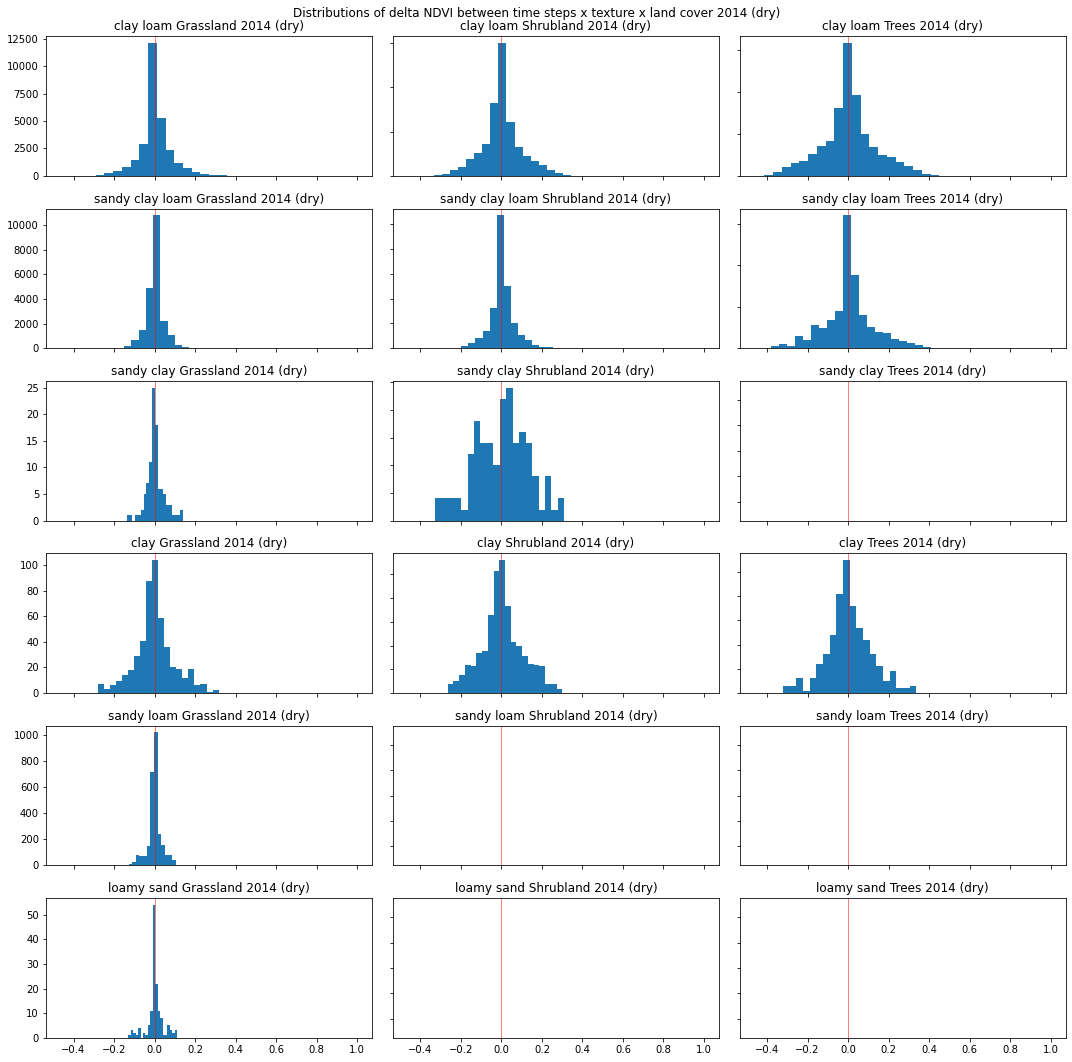

In [126]:
# df = df_full[df_full['Kenya_gras'] == 3]
# df = df_full[df_full['Kenya_shru'] == 2]
# df = df_full[df_full['Kenya_tree'] == 1]

fig, axs = plt.subplots(6, 3, sharex = True, figsize=(15,15))
axs[0, 0].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[0, 0].set_title('clay loam Grassland 2014 (dry)')
axs[0, 1].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[0, 1].set_title('clay loam Shrubland 2014 (dry)')
axs[0, 2].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[0, 2].set_title('clay loam Trees 2014 (dry)')

axs[1, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[1, 0].set_title('sandy clay loam Grassland 2014 (dry)')
axs[1, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[1, 1].set_title('sandy clay loam Shrubland 2014 (dry)')
axs[1, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[1, 2].set_title('sandy clay loam Trees 2014 (dry)')

axs[2, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[2, 0].set_title('sandy clay Grassland 2014 (dry)')
axs[2, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[2, 1].set_title('sandy clay Shrubland 2014 (dry)')
axs[2, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[2, 2].set_title('sandy clay Trees 2014 (dry)')

axs[3, 0].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[3, 0].set_title('clay Grassland 2014 (dry)')
axs[3, 1].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[3, 1].set_title('clay Shrubland 2014 (dry)')
axs[3, 2].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[3, 2].set_title('clay Trees 2014 (dry)')

axs[4, 0].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[4, 0].set_title('sandy loam Grassland 2014 (dry)')
axs[4, 1].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[4, 1].set_title('sandy loam Shrubland 2014 (dry)')
axs[4, 2].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[4, 2].set_title('sandy loam Trees 2014 (dry)')

axs[5, 0].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_gras'] == 3)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[5, 0].set_title('loamy sand Grassland 2014 (dry)')
axs[5, 1].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_shru'] == 2)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[5, 1].set_title('loamy sand Shrubland 2014 (dry)')
axs[5, 2].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_tree'] == 1)][df_full.columns[-89:-68]].to_numpy().flatten(), bins = 20)
axs[5, 2].set_title('loamy sand Trees 2014 (dry)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.axvline(x=0, color='r', linestyle='-', lw = .5)
plt.suptitle("Distributions of delta NDVI between time steps x texture x land cover 2014 (dry)")
plt.tight_layout()  
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\delta_t_dist_2014.jpg")

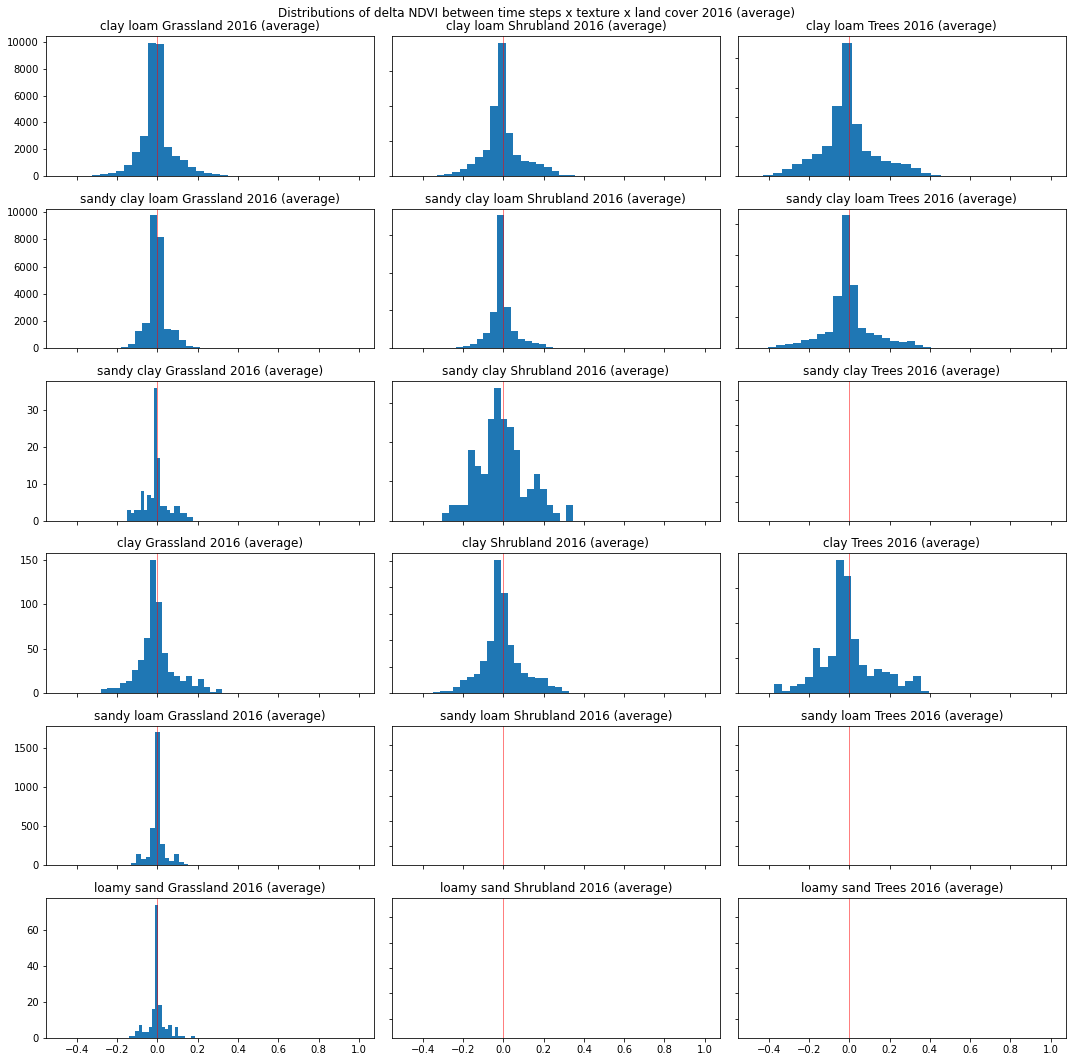

In [125]:
# df = df_full[df_full['Kenya_gras'] == 3]
# df = df_full[df_full['Kenya_shru'] == 2]
# df = df_full[df_full['Kenya_tree'] == 1]

fig, axs = plt.subplots(6, 3, sharex = True, figsize=(15,15))
axs[0, 0].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[0, 0].set_title('clay loam Grassland 2016 (average)')
axs[0, 1].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[0, 1].set_title('clay loam Shrubland 2016 (average)')
axs[0, 2].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[0, 2].set_title('clay loam Trees 2016 (average)')

axs[1, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[1, 0].set_title('sandy clay loam Grassland 2016 (average)')
axs[1, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[1, 1].set_title('sandy clay loam Shrubland 2016 (average)')
axs[1, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[1, 2].set_title('sandy clay loam Trees 2016 (average)')

axs[2, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45]].to_numpy().flatten(), bins = 20)
axs[2, 0].set_title('sandy clay Grassland 2016 (average)')
axs[2, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[2, 1].set_title('sandy clay Shrubland 2016 (average)')
axs[2, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[2, 2].set_title('sandy clay Trees 2016 (average)')

axs[3, 0].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[3, 0].set_title('clay Grassland 2016 (average)')
axs[3, 1].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[3, 1].set_title('clay Shrubland 2016 (average)')
axs[3, 2].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[3, 2].set_title('clay Trees 2016 (average)')

axs[4, 0].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[4, 0].set_title('sandy loam Grassland 2016 (average)')
axs[4, 1].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[4, 1].set_title('sandy loam Shrubland 2016 (average)')
axs[4, 2].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[4, 2].set_title('sandy loam Trees 2016 (average)')

axs[5, 0].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_gras'] == 3)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[5, 0].set_title('loamy sand Grassland 2016 (average)')
axs[5, 1].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_shru'] == 2)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[5, 1].set_title('loamy sand Shrubland 2016 (average)')
axs[5, 2].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_tree'] == 1)][df_full.columns[-68:-45:]].to_numpy().flatten(), bins = 20)
axs[5, 2].set_title('loamy sand Trees 2016 (average)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.axvline(x=0, color='r', linestyle='-', lw = .5)
plt.suptitle("Distributions of delta NDVI between time steps x texture x land cover 2016 (average)")
plt.tight_layout()      
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\delta_t_dist_2016.jpg")

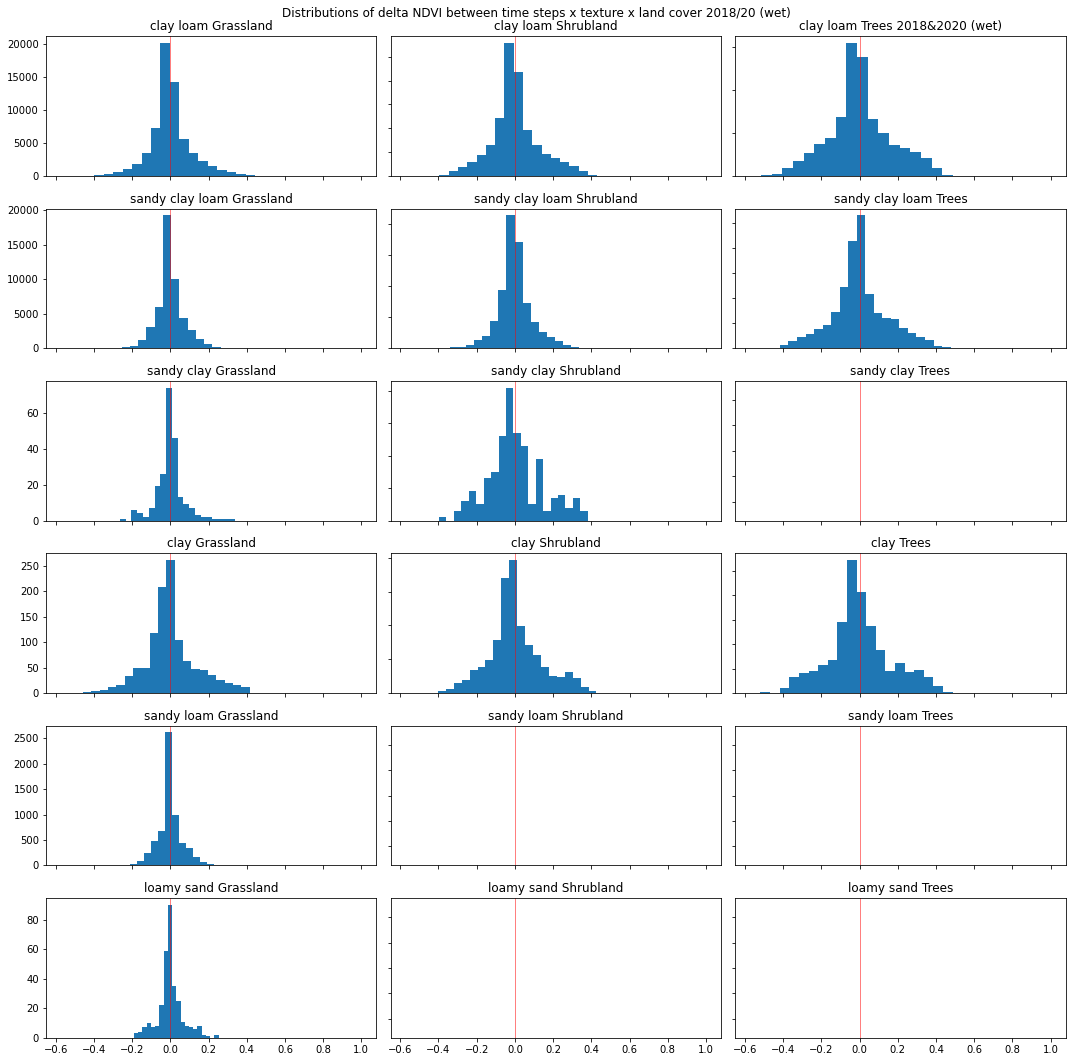

In [124]:
# df = df_full[df_full['Kenya_gras'] == 3]
# df = df_full[df_full['Kenya_shru'] == 2]
# df = df_full[df_full['Kenya_tree'] == 1]

fig, axs = plt.subplots(6, 3, sharex = True, figsize=(15,15))
axs[0, 0].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[0, 0].set_title('clay loam Grassland')
axs[0, 1].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[0, 1].set_title('clay loam Shrubland')
axs[0, 2].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[0, 2].set_title('clay loam Trees 2018&2020 (wet)')

axs[1, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[1, 0].set_title('sandy clay loam Grassland')
axs[1, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[1, 1].set_title('sandy clay loam Shrubland')
axs[1, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[1, 2].set_title('sandy clay loam Trees')

axs[2, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[2, 0].set_title('sandy clay Grassland')
axs[2, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[2, 1].set_title('sandy clay Shrubland')
axs[2, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[2, 2].set_title('sandy clay Trees')

axs[3, 0].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[3, 0].set_title('clay Grassland')
axs[3, 1].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[3, 1].set_title('clay Shrubland')
axs[3, 2].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[3, 2].set_title('clay Trees')

axs[4, 0].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[4, 0].set_title('sandy loam Grassland')
axs[4, 1].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[4, 1].set_title('sandy loam Shrubland')
axs[4, 2].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[4, 2].set_title('sandy loam Trees')

axs[5, 0].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_gras'] == 3)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[5, 0].set_title('loamy sand Grassland')
axs[5, 1].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_shru'] == 2)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[5, 1].set_title('loamy sand Shrubland')
axs[5, 2].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_tree'] == 1)][df_full.columns[-45:]].to_numpy().flatten(), bins = 20)
axs[5, 2].set_title('loamy sand Trees')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.axvline(x=0, color='r', linestyle='-', lw = .5)
plt.suptitle("Distributions of delta NDVI between time steps x texture x land cover 2018/20 (wet)")
plt.tight_layout()    
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\delta_t_dist_2018_20.jpg")

## distributions of stdv NDVI

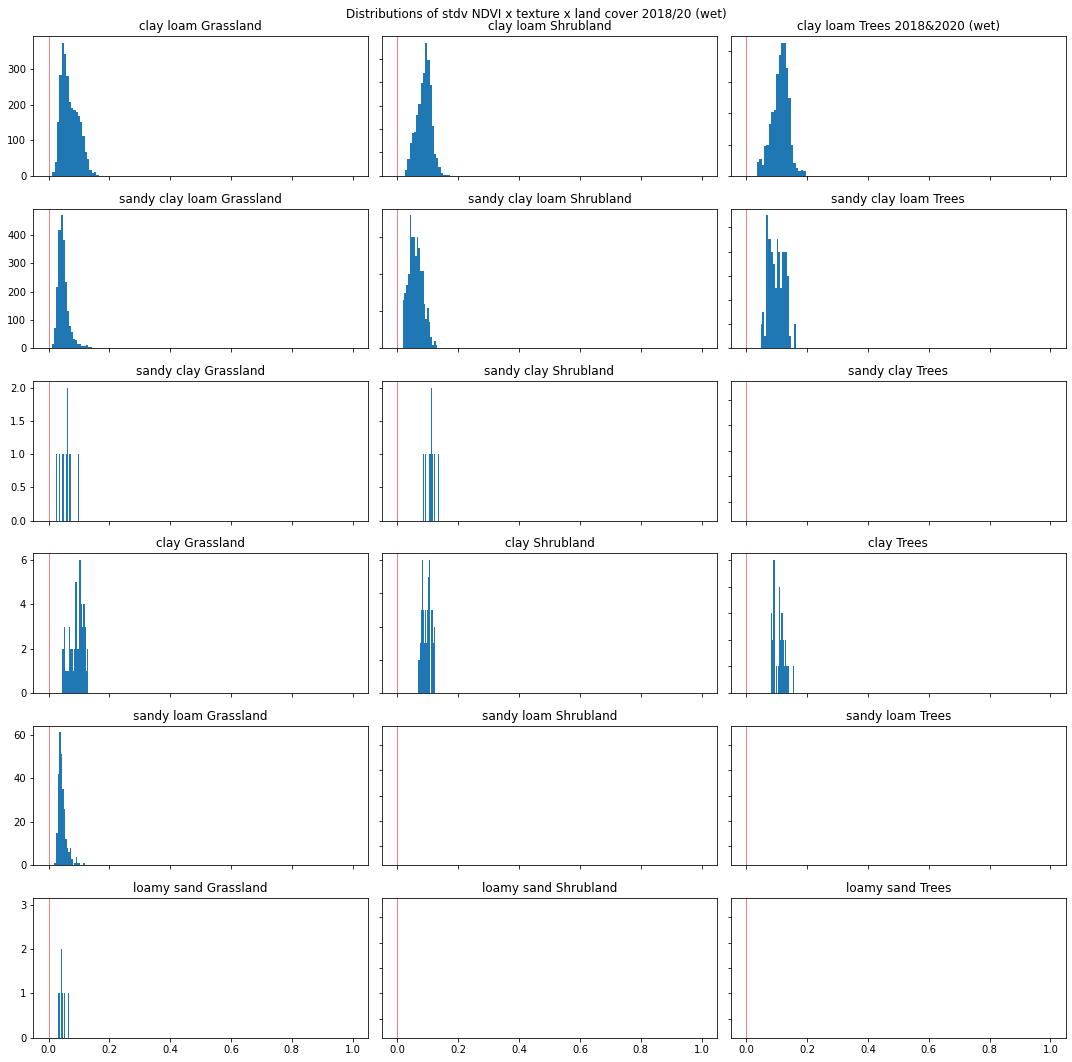

In [131]:
fig, axs = plt.subplots(6, 3, sharex = True, figsize=(15,15))
axs[0, 0].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[0, 0].set_title('clay loam Grassland')
axs[0, 1].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[0, 1].set_title('clay loam Shrubland')
axs[0, 2].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[0, 2].set_title('clay loam Trees 2018&2020 (wet)')

axs[1, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[1, 0].set_title('sandy clay loam Grassland')
axs[1, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[1, 1].set_title('sandy clay loam Shrubland')
axs[1, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[1, 2].set_title('sandy clay loam Trees')

axs[2, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[2, 0].set_title('sandy clay Grassland')
axs[2, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[2, 1].set_title('sandy clay Shrubland')
axs[2, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[2, 2].set_title('sandy clay Trees')

axs[3, 0].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[3, 0].set_title('clay Grassland')
axs[3, 1].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[3, 1].set_title('clay Shrubland')
axs[3, 2].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[3, 2].set_title('clay Trees')

axs[4, 0].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[4, 0].set_title('sandy loam Grassland')
axs[4, 1].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[4, 1].set_title('sandy loam Shrubland')
axs[4, 2].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[4, 2].set_title('sandy loam Trees')

axs[5, 0].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_gras'] == 3)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[5, 0].set_title('loamy sand Grassland')
axs[5, 1].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_shru'] == 2)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[5, 1].set_title('loamy sand Shrubland')
axs[5, 2].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_tree'] == 1)][['std2018', 'std2020']].to_numpy().flatten(), bins = 20)
axs[5, 2].set_title('loamy sand Trees')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.axvline(x=0, color='r', linestyle='-', lw = .5)
plt.suptitle("Distributions of stdv NDVI x texture x land cover 2018/20 (wet)")
plt.tight_layout()    
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\NDVI_std_dist_2018_20.jpg")

## distribution of number of peaks per year 

* these seem more random 

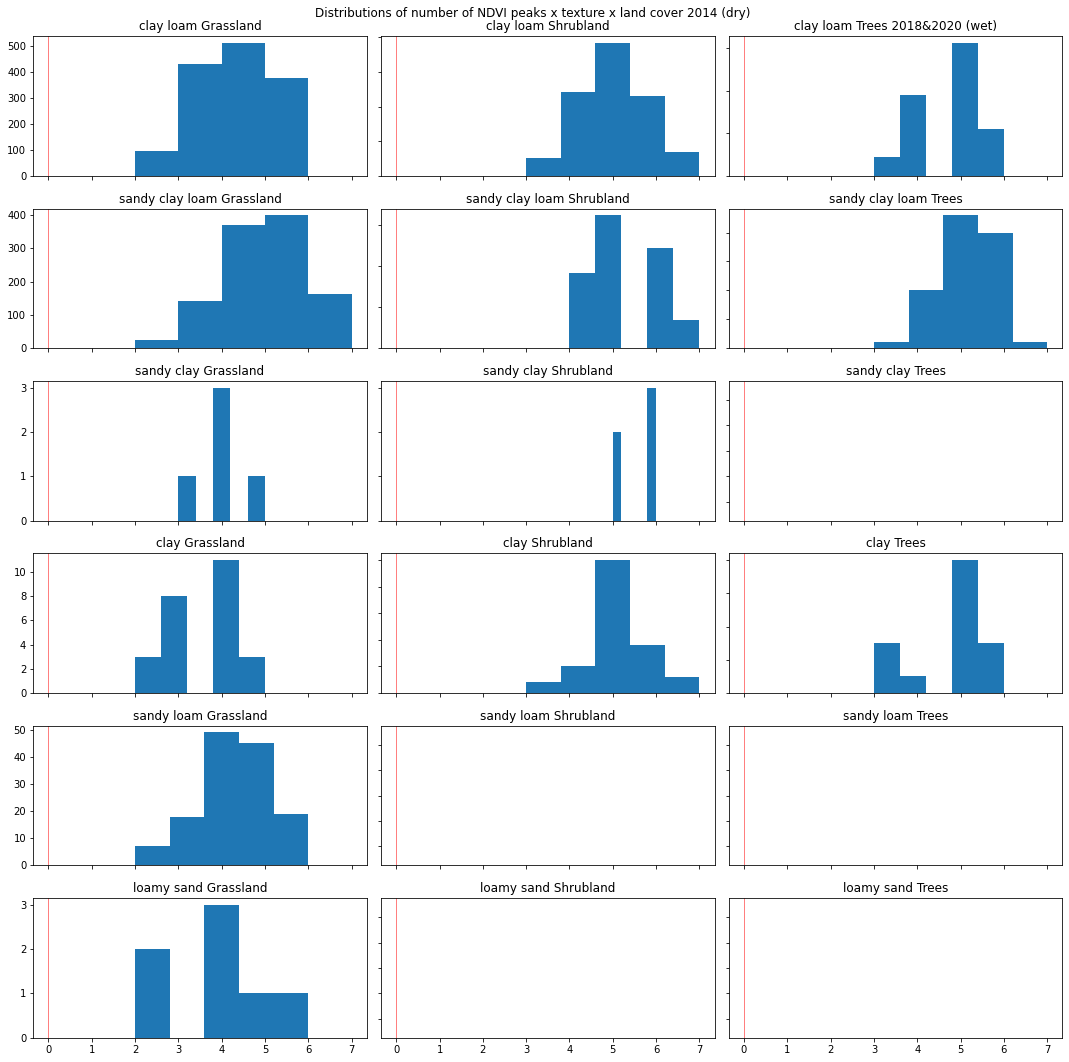

In [144]:
fig, axs = plt.subplots(6, 3, sharex = True, figsize=(15,15))
axs[0, 0].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[0, 0].set_title('clay loam Grassland')
axs[0, 1].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[0, 1].set_title('clay loam Shrubland')
axs[0, 2].hist(df_full[(df_full['top_texture'] == 'clay loam') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[0, 2].set_title('clay loam Trees 2018&2020 (wet)')

axs[1, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[1, 0].set_title('sandy clay loam Grassland')
axs[1, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[1, 1].set_title('sandy clay loam Shrubland')
axs[1, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay loam') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[1, 2].set_title('sandy clay loam Trees')

axs[2, 0].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[2, 0].set_title('sandy clay Grassland')
axs[2, 1].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[2, 1].set_title('sandy clay Shrubland')
axs[2, 2].hist(df_full[(df_full['top_texture'] == 'sandy clay') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[2, 2].set_title('sandy clay Trees')

axs[3, 0].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[3, 0].set_title('clay Grassland')
axs[3, 1].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[3, 1].set_title('clay Shrubland')
axs[3, 2].hist(df_full[(df_full['top_texture'] == 'clay') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[3, 2].set_title('clay Trees')

axs[4, 0].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[4, 0].set_title('sandy loam Grassland')
axs[4, 1].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[4, 1].set_title('sandy loam Shrubland')
axs[4, 2].hist(df_full[(df_full['top_texture'] == 'sandy loam') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[4, 2].set_title('sandy loam Trees')

axs[5, 0].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_gras'] == 3)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[5, 0].set_title('loamy sand Grassland')
axs[5, 1].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_shru'] == 2)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[5, 1].set_title('loamy sand Shrubland')
axs[5, 2].hist(df_full[(df_full['top_texture'] == 'loamy sand') & (df_full['Kenya_tree'] == 1)].num_peaks_2014.to_numpy().flatten(), bins = 5)
axs[5, 2].set_title('loamy sand Trees')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.axvline(x=0, color='r', linestyle='-', lw = .5)
plt.suptitle("Distributions of number of NDVI peaks x texture x land cover 2014 (dry)")
plt.tight_layout()    
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\NDVI_#peaks_dist_2014.jpg")

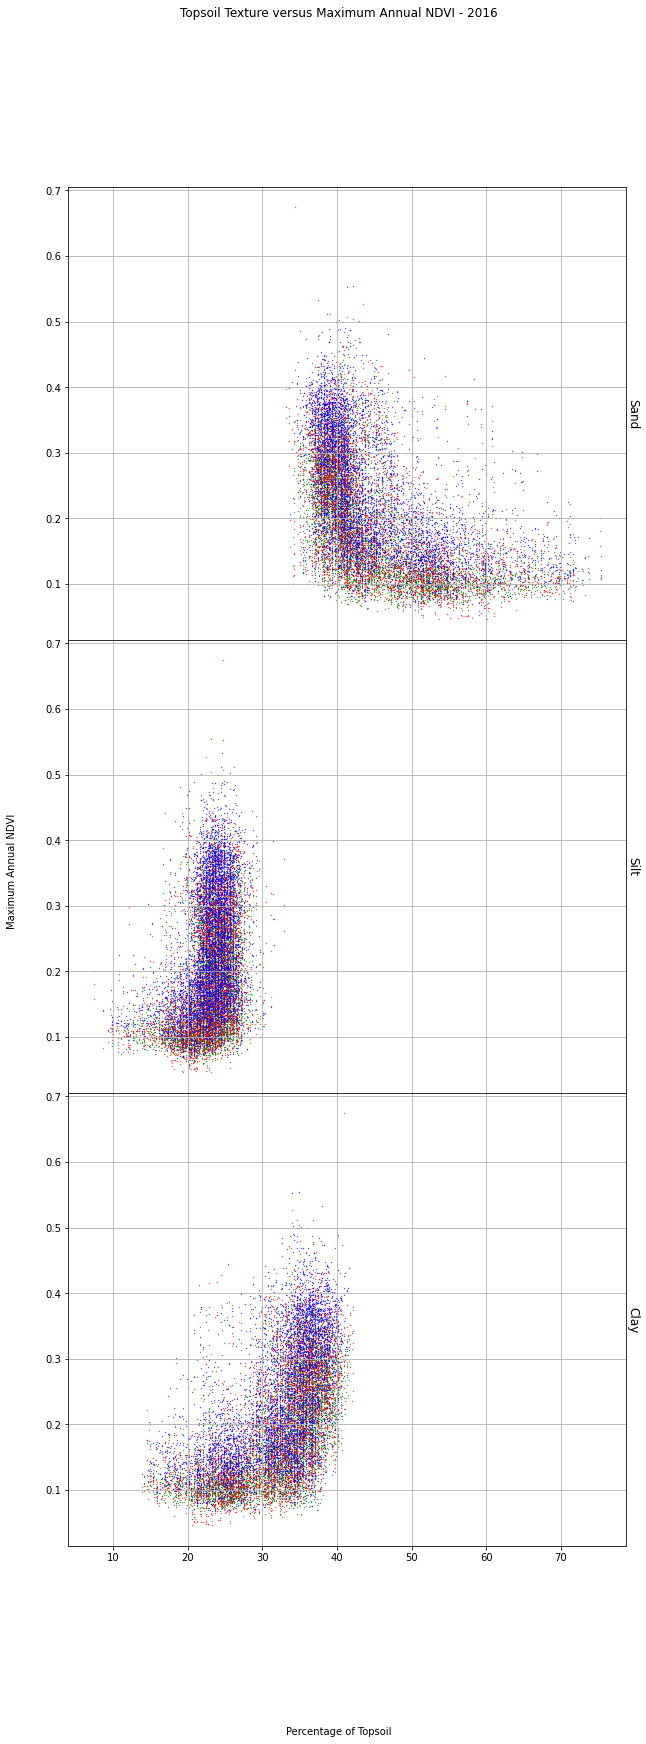

In [23]:
# plot all pixels annual max ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()
fig.set_size_inches(10,25)

ax1.scatter(df['sand_15_30']/10, df['F58_2014_ND'], s = .1, color = 'green', label = "Sand")
ax1.scatter(df['sand_15_30']/10, df['F58_2016_ND'], s = .1, color = 'red', label = "Sand")
ax1.scatter(df['sand_15_30']/10, df['F58_2018_ND'], s = .1, color = 'blue', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'black', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(df['silt_15_30']/10, df['F58_2014_ND'], s = .1, color = 'green', label = "Silt")
ax2.scatter(df['silt_15_30']/10, df['F58_2016_ND'], s = .1, color = 'red', label = "Silt")
ax2.scatter(df['silt_15_30']/10, df['F58_2018_ND'], s = .1, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'black', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(df['clay_15_30']/10, df['F58_2014_ND'], s = .1, color = 'green', label = "Clay")
ax3.scatter(df['clay_15_30']/10, df['F58_2016_ND'], s = .1, color = 'red', label = "Silt")
ax3.scatter(df['clay_15_30']/10, df['F58_2018_ND'], s = .1, color = 'blue', label = "Silt")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'black', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus Maximum Annual NDVI - 2016")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'Maximum Annual NDVI', va='center', rotation='vertical')
plt.savefig("topsoil_v_max_ndvi_by_precip.jpg", dpi = 500);

In [35]:
print ("NDVI correlated with sand, silt and clay content of topsoil")
print(df['F58_2016_ND'].corr(df['sand_15_30']))
print(df['F58_2016_ND'].corr(df['silt_15_30']))
print(df['F58_2016_ND'].corr(df['clay_15_30']))

NDVI correlated with sand, silt and clay content of topsoil
-0.5478860630543343
0.339046445841794
0.5660469036317471


In [36]:
print ("NDVI correlated with sand, silt and clay content of topsoil")
print(df['F58_2018_ND'].corr(df['sand_15_30']))
print(df['F58_2018_ND'].corr(df['silt_15_30']))
print(df['F58_2018_ND'].corr(df['clay_15_30']))

NDVI correlated with sand, silt and clay content of topsoil
-0.55393318340724
0.3411257157081636
0.5731703450782254


In [100]:
# Trees 
tree = df_full[df_full['Kenya_tree'] == 1]
# Shrubs 
shrub = df_full[df_full['Kenya_shru'] == 2]
# Grass 
grass = df_full[df_full['Kenya_gras'] == 3]

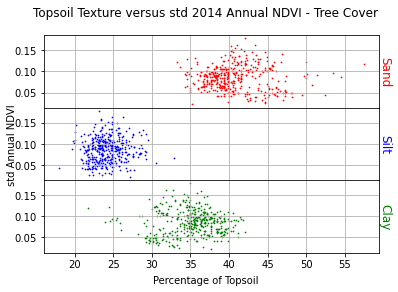

In [114]:
# plot all pixels annual mean2014 ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(tree['sand_15_30']/10, tree['std2014'], s = .5, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(tree['silt_15_30']/10, tree['std2014'], s = .5, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(tree['clay_15_30']/10, tree['std2014'], s = .5, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus std 2014 Annual NDVI - Tree Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'std Annual NDVI', va='center', rotation='vertical')
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\topsoil_v_std2014_ndvi_tree.jpg", dpi = 500);

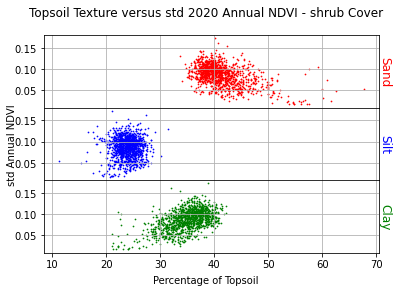

In [118]:
# plot all pixels annual mean2014 ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(shrub['sand_15_30']/10, shrub['std2020'], s = .5, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(shrub['silt_15_30']/10, shrub['std2020'], s = .5, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(shrub['clay_15_30']/10, shrub['std2020'], s = .5, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus std 2020 Annual NDVI - shrub Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'std Annual NDVI', va='center', rotation='vertical')
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\topsoil_v_std2020_ndvi_shrub.jpg", dpi = 500);

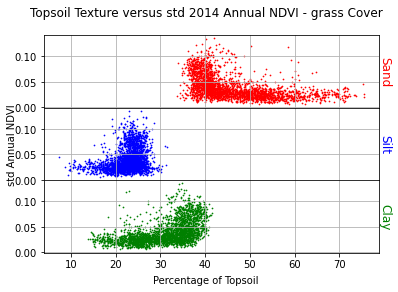

In [122]:
# plot all pixels annual mean2014 ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(grass['sand_15_30']/10, grass['std2014'], s = .5, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(grass['silt_15_30']/10, grass['std2014'], s = .5, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(grass['clay_15_30']/10, grass['std2014'], s = .5, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus std 2014 Annual NDVI - grass Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'std Annual NDVI', va='center', rotation='vertical')
plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\topsoil_v_std2014_ndvi_grass.jpg", dpi = 500);

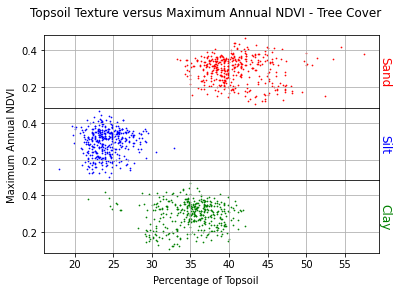

In [96]:
# plot all pixels annual max ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(tree['sand_15_30']/10, tree['F58_2014_ND'], s = .5, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(tree['silt_15_30']/10, tree['F58_2014_ND'], s = .5, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(tree['clay_15_30']/10, tree['F58_2014_ND'], s = .5, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus Maximum Annual NDVI - Tree Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'Maximum Annual NDVI', va='center', rotation='vertical')
plt.savefig("topsoil_v_max_ndvi_tree.jpg", dpi = 500);

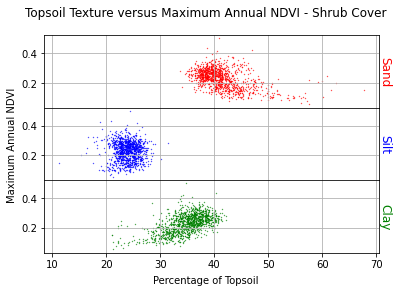

In [94]:
# plot all pixels annual max ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(shrub['sand_15_30']/10, shrub['F58_2014_ND'], s = .1, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(shrub['silt_15_30']/10, shrub['F58_2014_ND'], s = .1, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(shrub['clay_15_30']/10, shrub['F58_2014_ND'], s = .1, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus Maximum Annual NDVI - Shrub Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'Maximum Annual NDVI', va='center', rotation='vertical')
plt.savefig("topsoil_v_max_ndvi_shrub.jpg", dpi = 500);

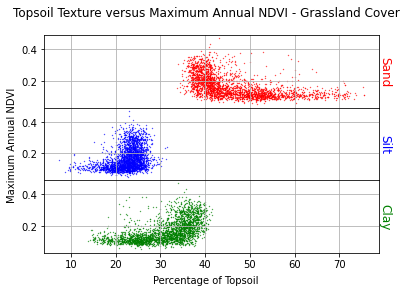

In [95]:
# plot all pixels annual max ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(grass['sand_15_30']/10, grass['F58_2014_ND'], s = .1, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(grass['silt_15_30']/10, grass['F58_2014_ND'], s = .1, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(grass['clay_15_30']/10, grass['F58_2014_ND'], s = .1, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus Maximum Annual NDVI - Grassland Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'Maximum Annual NDVI', va='center', rotation='vertical')
plt.savefig("topsoil_v_max_ndvi_grass.jpg", dpi = 500);